<a href="https://colab.research.google.com/github/jc020230/test4class/blob/main/Vehicle_Type_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
marquis03_vehicle_classification_path = kagglehub.dataset_download('marquis03/vehicle-classification')

print('Data source import complete.')


100%|██████████| 914M/914M [00:10<00:00, 90.0MB/s]

Extracting files...


Data source import complete.


# 1. Importing all the libraries

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import os

from copy import deepcopy
from sklearn.preprocessing import LabelEncoder

import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet50, vgg16, mobilenet_v2

import torch.nn as nn
import torch.nn.functional as F

# Downloading and creating dataset

The dataset consists of 2000 high-resolution images of 10 different classes.
- SUV
- Bus
- Family Sedan
- Fire Engine
- Heavy Truck
- Jeep
- Minibus
- Racing Car
- Taxi
- Truck

The dataset was downloaded from kaggle and here is the [Dataset Link](https://www.kaggle.com/datasets/marquis03/vehicle-classification)

In [3]:
import kagglehub

# Download the dataset
base_dir = kagglehub.dataset_download("marquis03/vehicle-classification")
print(f"{base_dir = }")

base_dir = '/root/.cache/kagglehub/datasets/marquis03/vehicle-classification/versions/1'


In [4]:
dataset = os.listdir(base_dir)
dataset

['test', 'train', 'val']


This function `create_df`, generates a pandas DataFrame containing image file paths, and optionally their associated labels, based on the structure of a directory.

### Outputs
- `Images` and `Labels` (if `labeled=True`)
- `Images` only (if `labeled=False`)

In [5]:
def create_df(base_dir, labeled=True):
    if labeled:
        dd = {"images": [], "labels": []}
        for i in os.listdir(base_dir):
            img_dirs = os.path.join(base_dir, i)
            for j in os.listdir(img_dirs):
                img = os.path.join(img_dirs, j)
                dd["images"] += [img]
                dd["labels"] += [i]

    else:
        dd = {"images": []}
        for i in os.listdir(base_dir):
            img_dirs = os.path.join(base_dir, i)
            dd["images"] += [img_dirs]

    return pd.DataFrame(dd)

In [6]:
train = create_df(os.path.join(base_dir, "train"))
val = create_df(os.path.join(base_dir, "val"))
test = create_df(os.path.join(base_dir, "test"), False)

In [7]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  1400 non-null   object
 1   labels  1400 non-null   object
dtypes: object(2)
memory usage: 22.0+ KB
None


`LabelEncoder()` ensures that the categorical labels in the dataset is encoded as consistent numerical values, which is often required for machine learning models that work with numerical data.

In [8]:
le = LabelEncoder()
train["labels"] = le.fit_transform(train.loc[:, "labels"].values)
val["labels"] = le.transform(val.loc[:, "labels"].values)

In [9]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  1400 non-null   object
 1   labels  1400 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 22.0+ KB
None


In [10]:
# Constants

MAX_EPOCHS = 20
LR = 1e-5
BATCH_SIZE = 32
IM_SIZE= 224
STEP = 5
GAMMA = 0.2
DECAY = 0.9
NUM_CLASSES = train["labels"].nunique()

This block defines a transformation pipeline using PyTorch's transforms module.The transformations are applied to preprocess images before feeding them into a machine learning model.

**Transformation Pipeline:**

1. `transforms.ToPILImage():` Converts the input image (in NumPy format) to a PIL Image.
2. `transforms.ToTensor():` Converts the PIL Image to a PyTorch tensor, scaling pixel values to the range [0, 1].
3. `transforms.Resize((IM_SIZE, IM_SIZE)):` Resizes the image to the specified dimensions (IM_SIZE x IM_SIZE).

In [11]:
train_transform = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

`ImageDataset` defines a custom PyTorch dataset class, designed to handle image data and their corresponding labels. It simplifies loading and preprocessing images for training machine learning models.

In [12]:
class ImageDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx, 0]
        label = self.data.iloc[idx, -1]

        # Load image
        image = Image.open(image_path).convert('RGB')

        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)

        return image, label

In [13]:
train_ds = ImageDataset(train, train_transform)
val_ds = ImageDataset(val, val_transform)
test_ds = ImageDataset(test)

(np.float64(-0.5), np.float64(1116.5), np.float64(792.5), np.float64(-0.5))

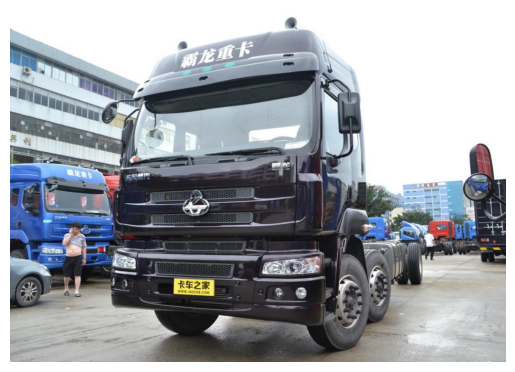

In [14]:
plt.imshow(test_ds[1][0]) # test_ds[idx][0:images]
plt.axis("off")

In [15]:
print(f"{len(train_ds[0][0][0][0]) = }")
print()
print(train_ds[0][0][0][0])
# train[idx][0:image, 1:label][Channel: RGB][transformed pixel values of nth row][nth column]

len(train_ds[0][0][0][0]) = 224

tensor([-2.1179, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179,
         1.3927,  1.3927,  1.3927,  1.3927,  1.3927,  1.3927,  1.3927,  1.3927,
         1.3927,  1.3755,  1.3584,  1.3584,  1.3755,  1.3927,  1.3927,  1.3755,
         1.3584,  1.3755,  1.3755,  1.3755,  1.3755,  1.3755,  1.3755,  1.3755,
         1.3755,  1.3755,  1.3584,  1.3584,  1.3413,  1.3413,  1.3584,  1.3584,
         1.3413,  1.3584,  1.3584,  1.3755,  1.3584,  1.3584,  1.3413,  1.3413,
         1.3413,  1.3584,  1.3413,  1.3413,  1.3413,  1.3584,  1.3584,  1.3584,
         1.3584,  1.3755,  1.3755,  1.3755,  1.3755,  1.3755,  1.3755,  1.3755,
         1.3755,  1.3584,  1.3755,  1.3755,  1.3755,  1.3755,  1.3755,  1.3413,
         1.3413,  1.3755,  1.3927,  1.4098,  1.4098,  1.3755,  1.3755,  1.3927,
         1.4098,  1.4440,  1.4612,  1.4783,  1.4612,  1.4612,  1.4612,  1.4612,
         1.4783,  1.4954,  1.5125,  1.5125,  1.5125,  1.5297,  1.5639,  1.5639,
       

In [16]:
print(np.array(train_ds[0][0]).shape)

(3, 224, 224)


In [17]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


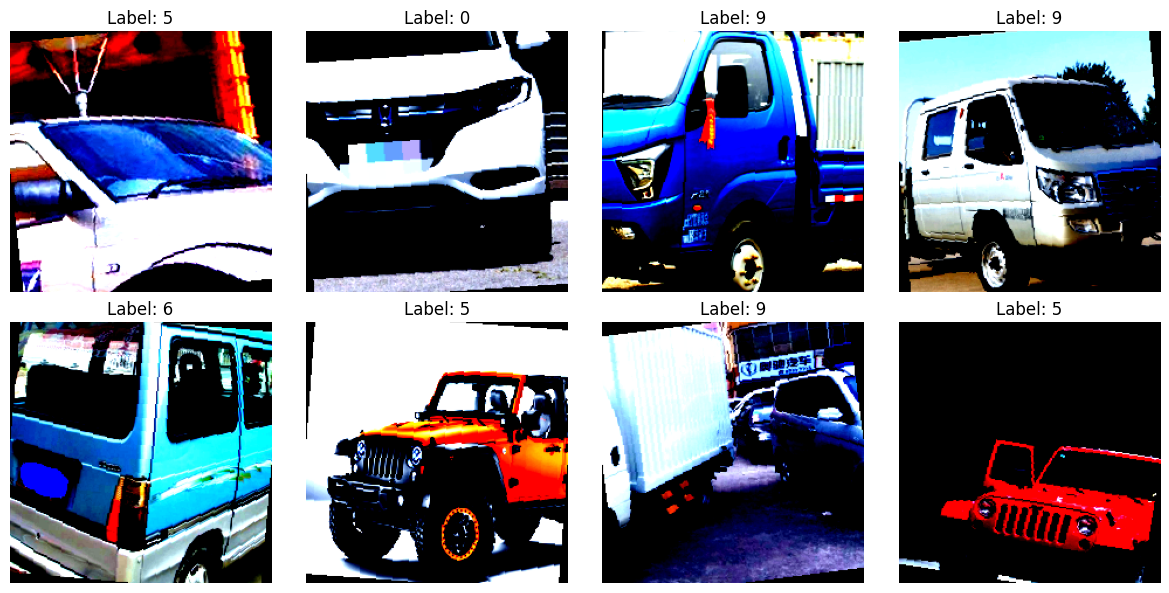

In [18]:
# Get the next batch of images and labels
images, labels = next(iter(train_loader))

images = images.permute(0, 2, 3, 1)  # Change shape from (8, C, H, W) to (8, H, W, C)

fig, axes = plt.subplots(2, 4, figsize=(12, 6))  # 2 rows, 4 columns

for i in range(8):
    ax = axes[i // 4, i % 4]
    ax.imshow(images[i].numpy())
    ax.set_title(f"Label: {labels[i].item()}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Creating and Downloading Model architectures

In [19]:
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Creating a simple CNN model for comparison

In [20]:
class MyCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(MyCNN, self).__init__()

        # First convolution block
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        # Second convolution block
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        # Third convolution block
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        # Fourth convolution block
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        # Adaptive pooling to handle different input sizes
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))

        # Fully connected layers with dropout
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

my_model = MyCNN().to(device)

summary(my_model, (3, 224, 224), device = device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

### Downloading other model architectures and modifying the output fc layer

In [21]:
resnet = resnet50(weights=None).to(device)
resnet.fc = nn.Linear(resnet.fc.in_features, NUM_CLASSES).to(device)

vgg = vgg16(weights=None).to(device)
vgg.classifier[6] = nn.Linear(vgg.classifier[6].in_features, NUM_CLASSES).to(device)

mobilenet = mobilenet_v2(weights=None).to(device)
mobilenet.classifier[1] = nn.Linear(mobilenet.classifier[1].in_features, NUM_CLASSES).to(device)

In [22]:
# Print model summaries
print("ResNet50 Summary:")
summary(resnet, (3, 224, 224), device=device.type)

print("\nVGG16 Summary:")
summary(vgg, (3, 224, 224), device=device.type)

print("\nMobileNetV2 Summary:")
summary(mobilenet, (3, 224, 224), device=device.type)

ResNet50 Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14 

In [23]:
models = {
    'my_model': my_model,
    'resnet': resnet,
    'vgg16': vgg,
    'mobilenet': mobilenet
}

**Training the models**

In [24]:
# import shutil
# shutil.rmtree("/kaggle/working/")

In [25]:
def train_model(model, model_name, train_loader, val_loader, num_epochs=50):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    # Using AdamW optimizer with weight decay
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

    # Cosine Annealing scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

    best_val_acc = 0.0
    patience = 10  # Increased patience
    patience_counter = 0

    scaler = torch.cuda.amp.GradScaler()  # For mixed precision training

    train_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # Mixed precision training
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            if batch_idx % 20 == 0:
                print(f'Epoch: {epoch+1} [{batch_idx * len(images)}/{len(train_loader.dataset)} '
                      f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100. * correct / total

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 60)

        scheduler.step()

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
            }, f'{model_name}_best.pth')
            patience_counter = 0
            print(f'New best model saved with validation accuracy: {val_acc:.2f}%')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch + 1} epochs')
            break

    return train_losses, train_accs, val_accs



Training my_model...


<ipython-input-25-cb9cd0f22577>:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # For mixed precision training
<ipython-input-25-cb9cd0f22577>:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch: 1 [0/1400 (0%)]	Loss: 2.399170
Epoch: 1 [640/1400 (45%)]	Loss: 2.843048
Epoch: 1 [1280/1400 (91%)]	Loss: 2.563690
Epoch 1/50:
Train Loss: 6.6750, Train Acc: 10.36%
Val Loss: 2.2787, Val Acc: 16.00%
------------------------------------------------------------
New best model saved with validation accuracy: 16.00%
Epoch: 2 [0/1400 (0%)]	Loss: 2.492279
Epoch: 2 [640/1400 (45%)]	Loss: 2.366516
Epoch: 2 [1280/1400 (91%)]	Loss: 2.340332
Epoch 2/50:
Train Loss: 2.3673, Train Acc: 11.21%
Val Loss: 2.2441, Val Acc: 16.00%
------------------------------------------------------------
Epoch: 3 [0/1400 (0%)]	Loss: 2.413879
Epoch: 3 [640/1400 (45%)]	Loss: 2.330444
Epoch: 3 [1280/1400 (91%)]	Loss: 2.609070
Epoch 3/50:
Train Loss: 2.3275, Train Acc: 9.36%
Val Loss: 2.2442, Val Acc: 18.50%
------------------------------------------------------------
New best model saved with validation accuracy: 18.50%
Epoch: 4 [0/1400 (0%)]	Loss: 2.381287
Epoch: 4 [640/1400 (45%)]	Loss: 2.333862
Epoch: 4 [1280/1

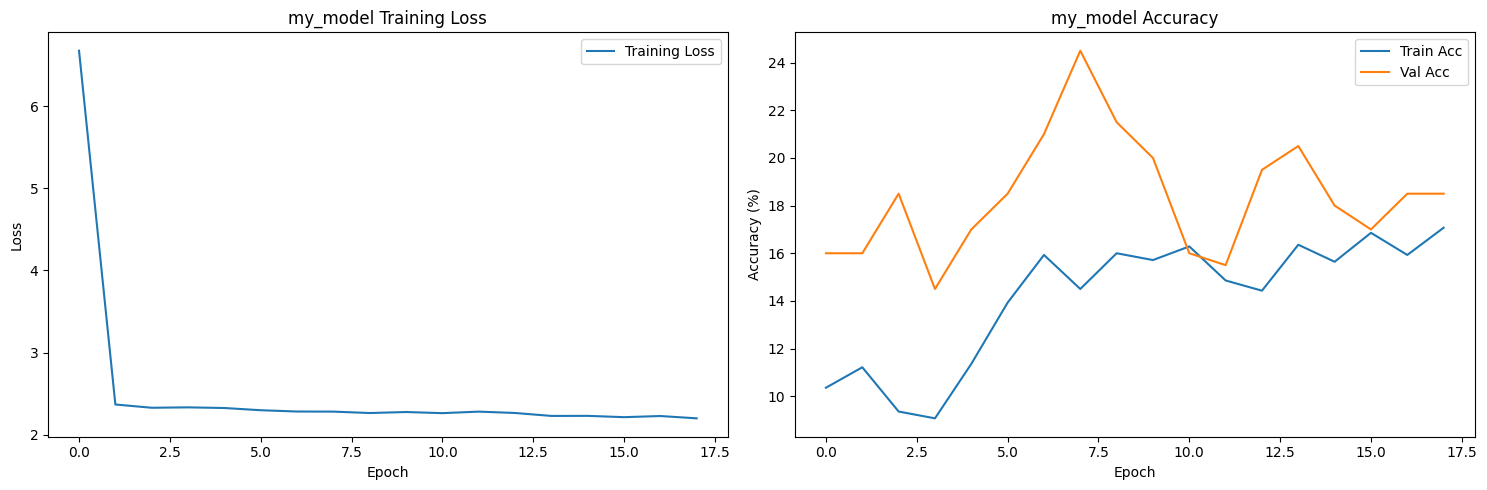


Training resnet...
Epoch: 1 [0/1400 (0%)]	Loss: 2.506500
Epoch: 1 [640/1400 (45%)]	Loss: 2.743174
Epoch: 1 [1280/1400 (91%)]	Loss: 2.379517
Epoch 1/50:
Train Loss: 2.5571, Train Acc: 15.93%
Val Loss: 2.0433, Val Acc: 23.50%
------------------------------------------------------------
New best model saved with validation accuracy: 23.50%
Epoch: 2 [0/1400 (0%)]	Loss: 2.293503
Epoch: 2 [640/1400 (45%)]	Loss: 2.180939
Epoch: 2 [1280/1400 (91%)]	Loss: 2.301483
Epoch 2/50:
Train Loss: 2.2022, Train Acc: 22.14%
Val Loss: 1.9032, Val Acc: 45.50%
------------------------------------------------------------
New best model saved with validation accuracy: 45.50%
Epoch: 3 [0/1400 (0%)]	Loss: 2.254816
Epoch: 3 [640/1400 (45%)]	Loss: 1.794182
Epoch: 3 [1280/1400 (91%)]	Loss: 2.148834
Epoch 3/50:
Train Loss: 2.0749, Train Acc: 28.86%
Val Loss: 1.7896, Val Acc: 37.00%
------------------------------------------------------------
Epoch: 4 [0/1400 (0%)]	Loss: 2.159500
Epoch: 4 [640/1400 (45%)]	Loss: 2.06

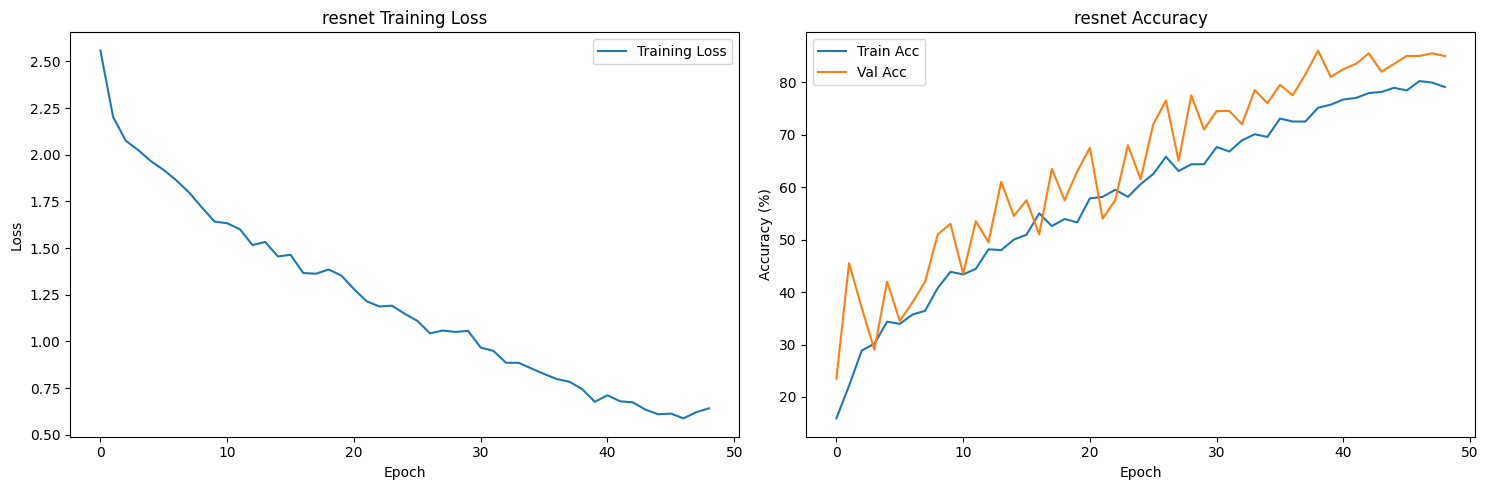


Training vgg16...
Epoch: 1 [0/1400 (0%)]	Loss: 2.293823
Epoch: 1 [640/1400 (45%)]	Loss: 2.342285
Epoch: 1 [1280/1400 (91%)]	Loss: 2.302307
Epoch 1/50:
Train Loss: 184.1413, Train Acc: 9.00%
Val Loss: 2.3042, Val Acc: 10.00%
------------------------------------------------------------
New best model saved with validation accuracy: 10.00%
Epoch: 2 [0/1400 (0%)]	Loss: 2.302063
Epoch: 2 [640/1400 (45%)]	Loss: 2.303406
Epoch: 2 [1280/1400 (91%)]	Loss: 2.302002
Epoch 2/50:
Train Loss: 2.3038, Train Acc: 8.86%
Val Loss: 2.3027, Val Acc: 10.00%
------------------------------------------------------------
Epoch: 3 [0/1400 (0%)]	Loss: 2.298767
Epoch: 3 [640/1400 (45%)]	Loss: 2.301819
Epoch: 3 [1280/1400 (91%)]	Loss: 2.303467
Epoch 3/50:
Train Loss: 2.3030, Train Acc: 10.14%
Val Loss: 2.3024, Val Acc: 10.00%
------------------------------------------------------------
Epoch: 4 [0/1400 (0%)]	Loss: 2.300537
Epoch: 4 [640/1400 (45%)]	Loss: 2.301208
Epoch: 4 [1280/1400 (91%)]	Loss: 2.306946
Epoch 4/

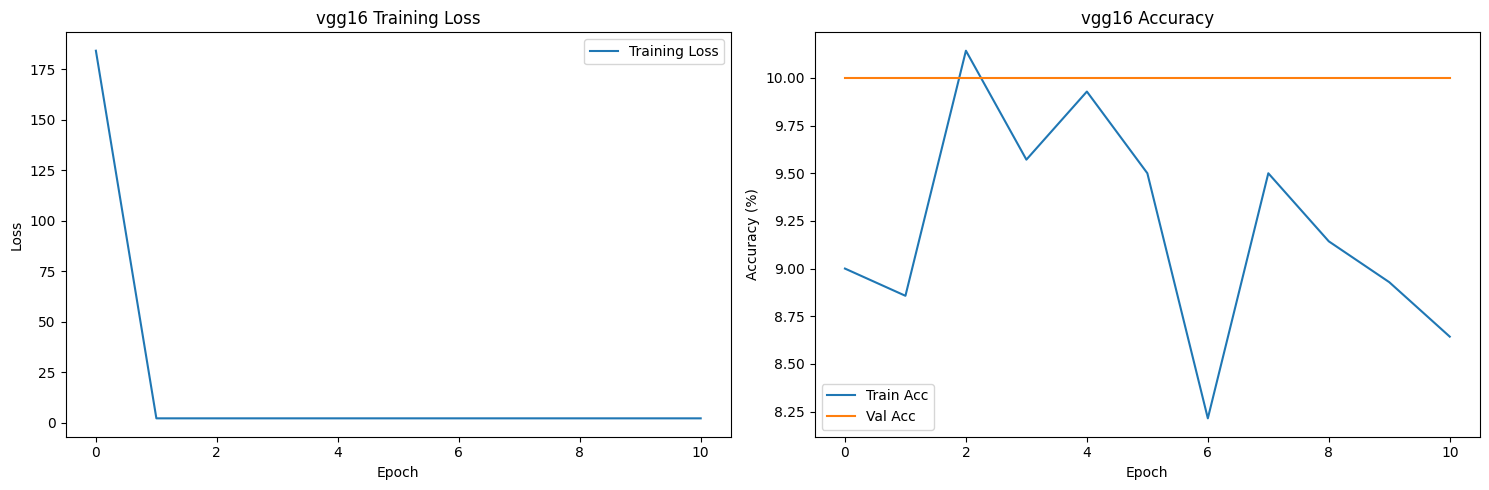


Training mobilenet...
Epoch: 1 [0/1400 (0%)]	Loss: 2.324310
Epoch: 1 [640/1400 (45%)]	Loss: 2.424988
Epoch: 1 [1280/1400 (91%)]	Loss: 2.079906
Epoch 1/50:
Train Loss: 2.3154, Train Acc: 15.43%
Val Loss: 2.9056, Val Acc: 10.00%
------------------------------------------------------------
New best model saved with validation accuracy: 10.00%
Epoch: 2 [0/1400 (0%)]	Loss: 2.222229
Epoch: 2 [640/1400 (45%)]	Loss: 2.278366
Epoch: 2 [1280/1400 (91%)]	Loss: 2.334778
Epoch 2/50:
Train Loss: 2.1945, Train Acc: 20.71%
Val Loss: 1.8110, Val Acc: 36.00%
------------------------------------------------------------
New best model saved with validation accuracy: 36.00%
Epoch: 3 [0/1400 (0%)]	Loss: 2.011658
Epoch: 3 [640/1400 (45%)]	Loss: 2.024536
Epoch: 3 [1280/1400 (91%)]	Loss: 1.784790
Epoch 3/50:
Train Loss: 2.0285, Train Acc: 26.79%
Val Loss: 1.9463, Val Acc: 32.50%
------------------------------------------------------------
Epoch: 4 [0/1400 (0%)]	Loss: 1.933746
Epoch: 4 [640/1400 (45%)]	Loss: 1

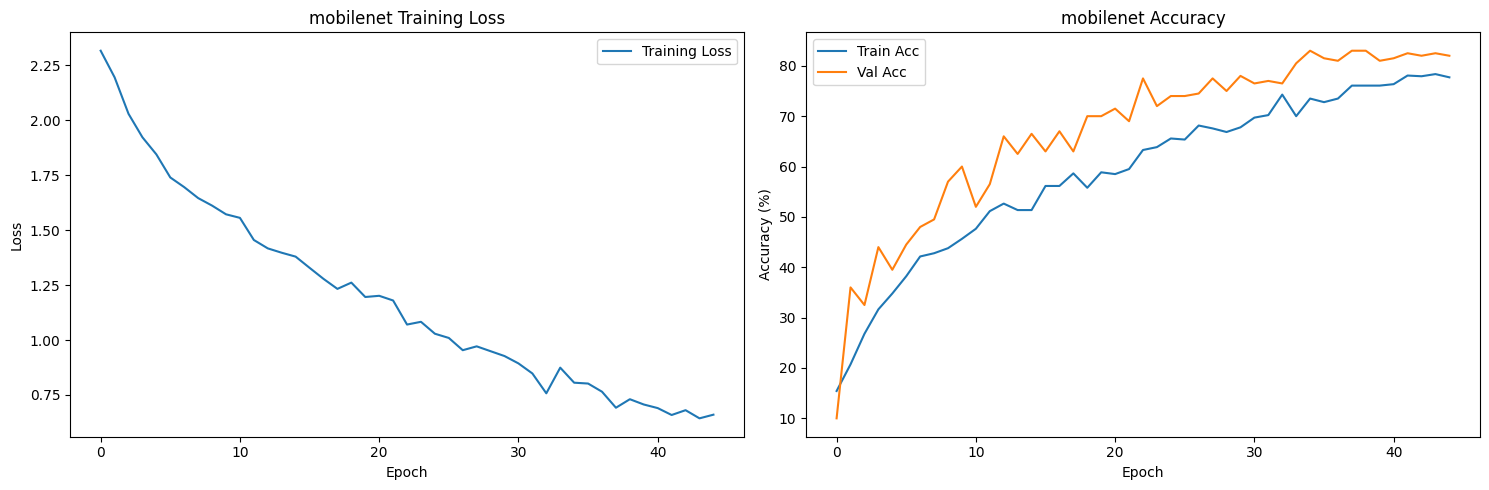

In [26]:
for name, model in models.items():
    print(f"\nTraining {name}...")
    print("=" * 60)
    train_losses, train_accs, val_accs = train_model(model, name, train_loader, val_loader)

    # Plot training curves
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.title(f'{name} Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.title(f'{name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{name}_training.png')
    plt.show()